# Nodule Detection

Arnau Camprubí, Ricardo Martín, Martí Miranda, Arnau Puche

In [ ]:
import os
print(os.getcwd())

os.chdir('../Deb/Code')
print(os.getcwd())

/Users/puche99/Desktop/MEDICAL/urxe/2- diagnosis challenge/Notebook
/Users/puche99/Desktop/MEDICAL/urxe/2- diagnosis challenge/Deb/Code


In [ ]:
!pip install nibabel
!pip install 'SimpleITK>=2.0.0,<2.0.1' 
#--force-reinstall
import nibabel as nib
import os
import cv2
import numpy as np
import IOFunctions
import VolumeCutBrowser
from skimage import filters
from skimage import exposure
import matplotlib.pyplot as plt
from scipy.ndimage import binary_fill_holes
from skimage.morphology import convex_hull_image

In [ ]:
def is_directory(name: str) -> bool:
    """
    Returns if a string belongs to a directory or file name.
    """
    return not "." in name

In [ ]:
# Getting some paths
os.chdir('../Dades')
print(os.getcwd())

current_directory = os.getcwd()

/Users/puche99/Desktop/MEDICAL/urxe/2- diagnosis challenge/Deb/Dades


In [ ]:
diagnosis_directory = os.path.join(current_directory, "Diagnosis")
roi_directory = os.path.join(current_directory, "Nodules")
patient_directories = [x for x in os.listdir(diagnosis_directory) if is_directory(x)]

In [ ]:
def get_nii_and_csv_names(elements: list) -> (str, str):
    """
    Returns nii (nifti) and acsv file names based on their extension.
    """
    for element in elements:
        file_name = os.path.basename(element)
        if ".nii" in file_name:
            nii = element
        elif ".acsv" in file_name:
            acsv = element
    return nii, acsv


def get_file_path(diagnosis_directory, patient_directory, file_name):
    return os.path.join(diagnosis_directory, patient_directory, file_name)

In [ ]:
def get_acsv_info(acsv_path: os.path) -> list:
    """
    Returns a list with useful information from acsv file, such as the two
    points.
    """
    buffer = []
    with open(acsv_path, "r") as acsv:
        line = acsv.readline()
        while line:
            line = acsv.readline()
            if "#" not in line:
                line = line.strip()
                buffer.append(line)
    return buffer


def load_point(coords_description: str) -> list:
    """
    Returns a list with point coordinates, based on string with coordinates
    from acsv file.
    """
    coords_description = coords_description.split("|")
    point = np.array([float(x) for x in coords_description[1:5]])
    return point

def distance_between_points(a: np.array, b: np.array) -> float:
    """
    Returns euclidean distance between points a and b.
    """
    a, b = np.array(a), np.array(b)
    return np.linalg.norm(b-a)


def world_to_array_coords(coords: np.array, affine_matrix: np.array) -> np.array:
    """
    Transforms world coordinates to voxel (array) and returns them, by applying
    dot product between affine matrix and point in world coordinates.
    """
    return np.array(np.dot(np.linalg.inv(affine_matrix), coords), dtype=np.int)


def return_3D_coords(lower_limit: np.array, upper_limit) -> np.array:
    x1, x2 = min(lower_limit[0], upper_limit[0]), max(lower_limit[0], upper_limit[0])
    y1, y2 = min(lower_limit[1], upper_limit[1]), max(lower_limit[1], upper_limit[1])
    z1, z2 = min(lower_limit[2], upper_limit[2]), max(lower_limit[2], upper_limit[2])
    return x1, x2, y1, y2, z1, z2


def load_roi_coords(acsv_info: list, affine_matrix: np.array) -> dict:
    """
    Reads points (center and edge) with world coordinates from acsv file,
    transforms them to voxel coordinates, returns a cube that contains the nodule.
    """
    roi_cube = {}
    center = load_point(acsv_info[0])
    radius = load_point(acsv_info[1])
    upper_limit_world = center + radius
    lower_limit_world = center - radius
    upper_limit_world[3] = lower_limit_world[3] = 1
    upper_limit = world_to_array_coords(upper_limit_world, affine_matrix)
    lower_limit = world_to_array_coords(lower_limit_world, affine_matrix)
    return lower_limit, upper_limit


def get_file_name_from_patient(patient_directory: str):
    """
    Returns file name for nodule.
    """
    return "nodule_" + patient_directory.split("_")[1] + ".nii"


def change_window_size(min_coord: int, max_coord: int, window_size: float) -> (int, int):
    """
    Returns min and max coord based on given window size.
    """
    diff_coord = (max_coord - min_coord) * (window_size) / 2
    min_coord -= diff_coord
    max_coord += diff_coord
    return int(min_coord), int(max_coord)

def get_roi(nifti_image: np.array, acsv_info: list, affine_matrix: np.array, window_size=100) -> np.array:
    """
    Returns nifti image cropped.
    """
    if window_size <= 0:
        return None
    window_size /= 100
    lower_limit, upper_limit = load_roi_coords(acsv_info, meta["affine"])
    x1, x2, y1, y2, z1, z2 = return_3D_coords(lower_limit, upper_limit)
    x1, x2 = change_window_size(x1, x2, window_size)
    y1, y2 = change_window_size(y1, y2, window_size)
    z1, z2 = change_window_size(z1, z2, window_size)
    return nifti_image[x1:x2, y1:y2, z1:z2]


def get_params_for_roi(diagnosis_directory: os.path, patient_directory: os.path) -> (np.array, dict, list):
    """
    Returns nifti image in the form of Numpy Array, meta information about it and a
    list called acsv_info, which contains coordinates of apoint and a vector.
    """
    elements = os.listdir(os.path.join(diagnosis_directory, patient_directory))
    nii_name, acsv_name = get_nii_and_csv_names(elements)
    nii_path = get_file_path(diagnosis_directory, patient_directory, nii_name)
    acsv_path = get_file_path(diagnosis_directory, patient_directory, acsv_name)
    nifti_image, meta = IOFunctions.load_nifti_img(nii_path)
    acsv_info = get_acsv_info(acsv_path)
    return nifti_image, meta, acsv_info


def proportions_are_valid(roi: np.array) -> bool:
    """
    Returns a boolean based on the proportions of the given array. If the array is
    too slender in any of its dimensions, we are not interested on it.
    """
    shapes = roi.shape
    dimensions = len(shapes)
    
    # Checking dimension proportions
    for dim_idx_1 in range(dimensions):
        for dim_idx_2 in range(dim_idx_1, dimensions):
            prop = shapes[dim_idx_1] / shapes[dim_idx_2]
            if not 1/3 < prop < 3.5:
                print(prop)
                return False
    return True


def write_roi(roi: np.array, meta: dict, roi_directory: os.path, patient_directory: os.path) -> None:
    """
    Writes nodule ROI to memory.
    """
    file_name = get_file_name_from_patient(patient_directory)
    IOFunctions.write_nifti_img(roi, meta, roi_directory, file_name)

In [ ]:
# Cropping and priting nodule ROIs in memory
for patient_directory in patient_directories:
    nifti_image, meta, acsv_info = get_params_for_roi(diagnosis_directory, patient_directory)
    roi = get_roi(nifti_image, acsv_info, meta["affine"], window_size=130)
    if proportions_are_valid(roi):
        write_roi(roi, meta, roi_directory, patient_directory)

saving:  /Users/puche99/Desktop/MEDICAL/urxe/2- diagnosis challenge/Deb/Dades/Nodules/nodule_47.nii
saving:  /Users/puche99/Desktop/MEDICAL/urxe/2- diagnosis challenge/Deb/Dades/Nodules/nodule_40.nii
saving:  /Users/puche99/Desktop/MEDICAL/urxe/2- diagnosis challenge/Deb/Dades/Nodules/nodule_38.nii
saving:  /Users/puche99/Desktop/MEDICAL/urxe/2- diagnosis challenge/Deb/Dades/Nodules/nodule_52.nii
saving:  /Users/puche99/Desktop/MEDICAL/urxe/2- diagnosis challenge/Deb/Dades/Nodules/nodule_33.nii
saving:  /Users/puche99/Desktop/MEDICAL/urxe/2- diagnosis challenge/Deb/Dades/Nodules/nodule_16.nii
saving:  /Users/puche99/Desktop/MEDICAL/urxe/2- diagnosis challenge/Deb/Dades/Nodules/nodule_35.nii
saving:  /Users/puche99/Desktop/MEDICAL/urxe/2- diagnosis challenge/Deb/Dades/Nodules/nodule_41.nii
saving:  /Users/puche99/Desktop/MEDICAL/urxe/2- diagnosis challenge/Deb/Dades/Nodules/nodule_20.nii
saving:  /Users/puche99/Desktop/MEDICAL/urxe/2- diagnosis challenge/Deb/Dades/Nodules/nodule_14.nii


In [ ]:
class ROI:
    def __init__(self, roi_array: np.array, roi_name):
        """
        Initializes a ROI object.
        """
        assert type(roi_array) is np.ndarray, "Argument has to be of type numpy.ndarray"
        assert roi_array.ndim == 3, "Argument needs to have 3 dimensions"
        self._array = roi_array
        self._nodule = None
        self._x, self._y, self._z = self._make_2d_slices()
        self._roi_name = roi_name
    
    @property
    def array(self) -> np.array:
        """
        self._array getter.
        """
        return self._array
    
    @property
    def nodule(self) -> np.array:
        """
        self._nodule getter.
        """
        return self._nodule
    
    @property
    def x(self) -> np.array:
        """
        self._x getter.
        """
        return self._x
    
    @property
    def y(self) -> np.array:
        """
        self._y getter.
        """
        return self._y
    
    @property
    def z(self) -> np.array:
        """
        self._y getter.
        """
        return self._z
    
    def _make_2d_slices(self, segmented=False) -> (np.array, np.array, np.array):
        """
        Returns three lists, with 2D images corresponding to slices of each of
        the three axis.
        """
        # Choosing source 3D image
        image_3d = self._array
        if segmented:
            image_3d = self._nodule
            
        # Splitting the 3D image for all axis
        x_plane = [array[0] for array in np.split(image_3d, len(image_3d[:, 0, 0]), axis=0)]
        y_plane = [array[0] for array in np.split(image_3d, len(image_3d[0, :, 0]), axis=1)]
        z_plane = [array[0] for array in np.split(image_3d, len(image_3d[0, 0, :]), axis=2)]
        return x_plane, y_plane, z_plane
    
    def reset_planes(self) -> None:
        """
        This function is used in order to reset slices from all axis to
        original, not segmented
        """
        self._x, self._y, self._z = self._make_2d_slices()
        
    def slices_are_segmented(self) -> bool:
        """
        Returns whether all slices (x, y and z) are segmented or not.
        """
        list_of_planes = [self._x, self._y, self._z]
        return any([len(np.unique(plane_array)) == 2 for plane_array in list_of_planes])
    
    def number_of_slices(self, list_of_images: list) -> int:
        """
        Returns the amount of images inside an axis. In other words, its length.
        """
        return len(list_of_images)
    
    def apply_otsu(self, image: np.array) -> np.array:
        """
        This function applies OTSU to the given image, which is a non supervised
        way of segmentation, then returns a binary image.
        """
        val = filters.threshold_otsu(image)
        
        return np.array(image > val -70, dtype=np.uint8)
    
    def _split_by_axis(self, image_3d: np.array) -> list:
        """
        Returns a list of 2D images from a 3D image.
        """
        return [image_2d[0] for image_2d in np.split(image_3d, len(image_3d[:, 0, 0]), axis=0)]
    
    def get_lung_mask(self, image_3d: np.array, threshold=-400) -> np.array:
        """
        This function builds a mask for the lung that can be found in any 3D
        ROI. It does so by:
            1. Binarizing the source 3D image
            2. Splitting the 3D image into several 2D ones
            3. Filling the holes such as the nodule itself
            4. Applying some morphological operations
        That process leaves a binary 3D image whose only non-zero values are
        the lung itself.
        """
        # Binarizing the 3D image
        binarized_image_3d = np.array(image_3d > threshold, dtype=np.uint8)
        
        # Splitting the 3D image into 2D images
        x_plane = self._split_by_axis(binarized_image_3d)
        
        kernel_fill_holes = np.ones((3,2))
        kernel_opening = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        
        """"""
        # Processing each 2D image separately
        for i in range(len(x_plane)):
            
            # Fill all the elements inside the lung
            no_holes = np.array(1-binary_fill_holes(
                1 - x_plane[i],
                structure=kernel_fill_holes
            ).astype(int), dtype=np.uint8)
            x_plane[i] = cv2.morphologyEx(no_holes, cv2.MORPH_OPEN, kernel_opening, iterations=3)
            
                
                
        for i in range(len(x_plane)):
            
            # Fill all the elements inside the lung
            no_holes = np.array(1-binary_fill_holes(
                1 - x_plane[i],
                structure=kernel_fill_holes
            ).astype(int), dtype=np.uint8)
            x_plane[i] = cv2.morphologyEx(no_holes, cv2.MORPH_OPEN, kernel_opening, iterations=3)
            
            rois_pegadas = ['nodule_25.nii','nodule_27.nii','nodule_34.nii','nodule_41.nii','nodule_42.nii']
            if self._roi_name in rois_pegadas:
                x_plane[i] = 1 - convex_hull_image(1 - x_plane[i])
            else:
                if 1 - x_plane[i].any():
                    x_plane[i] = 1 - convex_hull_image(1 - x_plane[i])
            
        # Stacking 2D images to bring back the 3D sense
        floodfilled = np.stack(x_plane, axis=0)
        return floodfilled
    
    def biggest_connected_component(self, image_3d: np.array, min_area=45) -> np.array:
        """
        This function splits the given 3D image into several 2D ones. Then,
        for each one of them finds the greatest connected component, and
        creates an array whose only non-zero values correspond to that
        connected component. Finally, it returns a 3D image.
        """
        # Splitting the 3D image
        x_plane = self._split_by_axis(image_3d)
        
        # Leaving only the greatest connected component for each 2D slice
        for i in range(len(x_plane)):
            
            # If there is any value different from zero
            if x_plane[i].any():
                nodule_2d_image = np.zeros_like(x_plane[i])
                labels, stats = cv2.connectedComponentsWithStats(x_plane[i], 4)[1:3]
                list_of_args = stats[1:, cv2.CC_STAT_AREA]
                largest_label = 1 + np.argmax(list_of_args)
                if list_of_args[largest_label-1] >= min_area:
                    nodule_2d_image[labels == largest_label] = 1
                x_plane[i] = nodule_2d_image
            
        # Stacking up all processed 2D slices
        nodule_image = np.stack(x_plane, axis=0)
        
        # Returning 3D images
        return nodule_image
        
    def segment(self) -> None:
        """
        This function segments the original 3D ROI image to get a binary 3D
        image of what the nodule represents.
        """
        # If segmentation has already been done, do nothing
        if self._nodule is not None:
            return None
        
        # Applying OTSU processing
        otsu_image = self.apply_otsu(self._array)
        plt.imshow(otsu_image[len(otsu_image)//2, :, :], cmap="gray")
        plt.show()
        
        # Creating the lung mask
        lung_mask = self.get_lung_mask(self._array, -400)

        
        # Getting all elements inside the lung
        result_image = np.array(1 - otsu_image == lung_mask, dtype=np.uint8)

        
        # Getting the greatest connected component
        self._nodule = self.biggest_connected_component(result_image)
        plt.imshow(self._nodule[len(self._nodule)//2, :, :], cmap="gray")
        plt.show()
        
        # Update slices for all axes
        self._x, self._y, self._z = self._make_2d_slices(segmented=True)

### SEGMENTACIÓ IMATGES i GUARDAR EN 3D

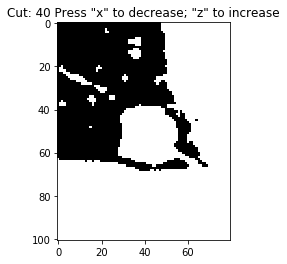

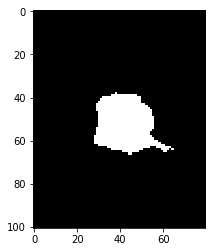

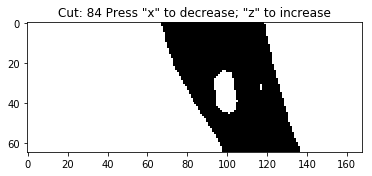

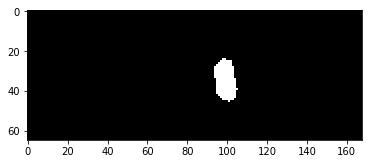

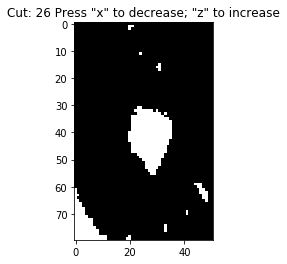

/Users/puche99/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:143: UserWarning: Input image is entirely zero, no valid convex hull. Returning empty image


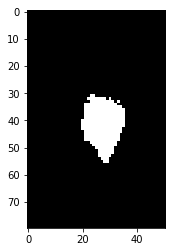

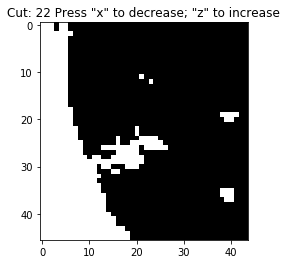

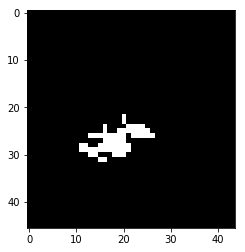

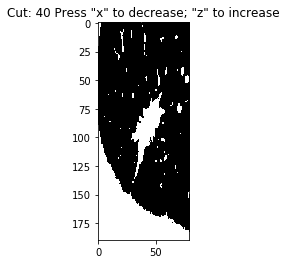

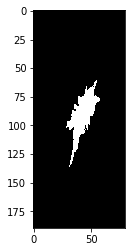

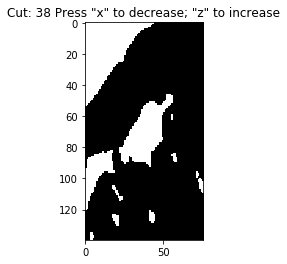

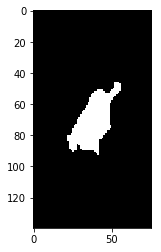

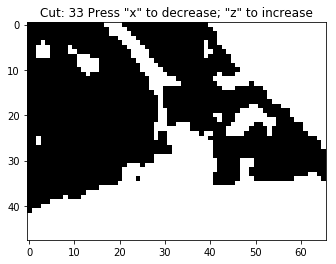

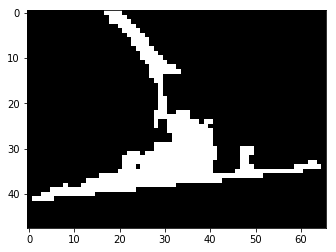

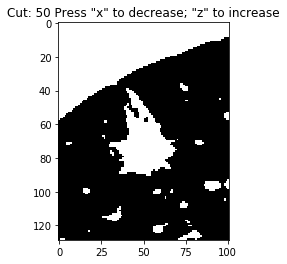

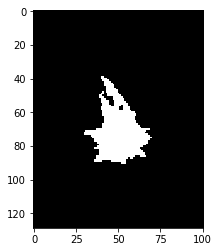

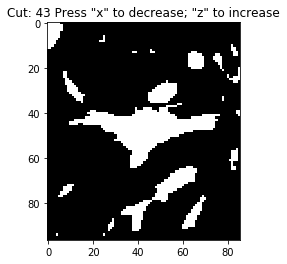

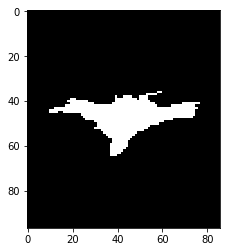

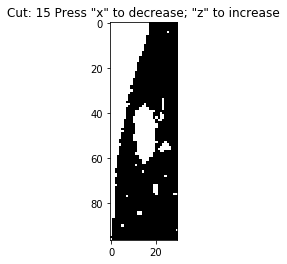

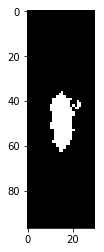

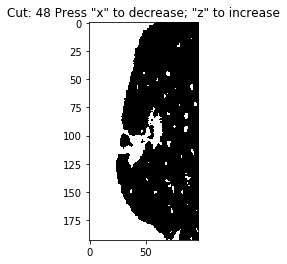

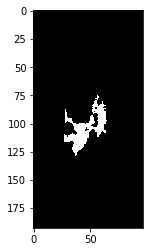

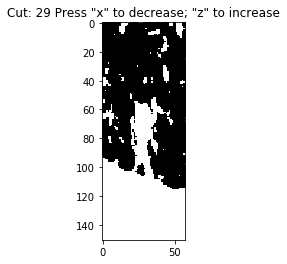

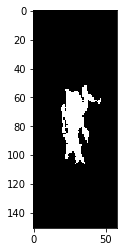

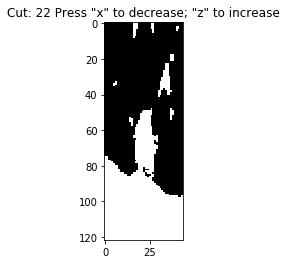

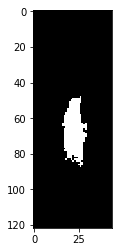

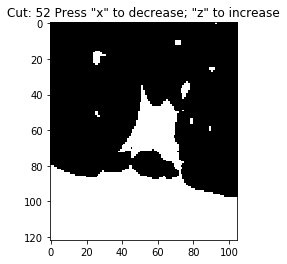

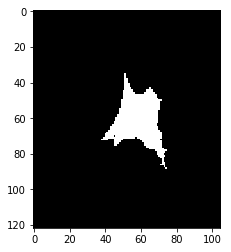

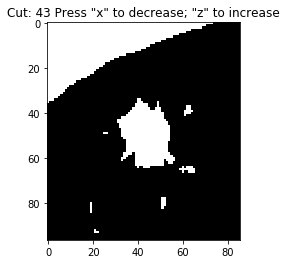

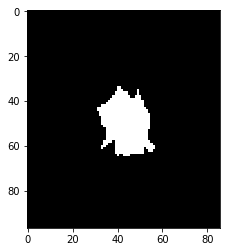

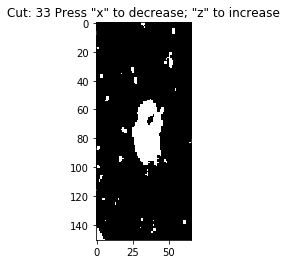

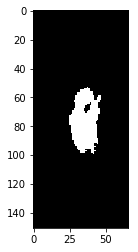

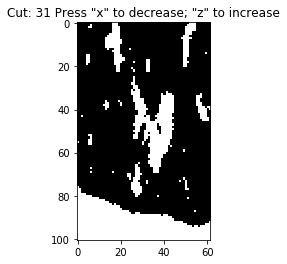

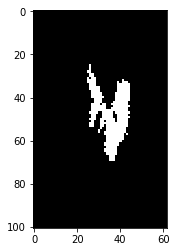

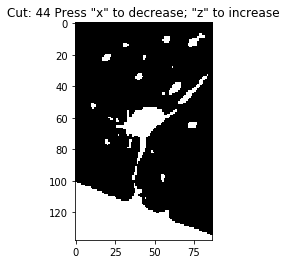

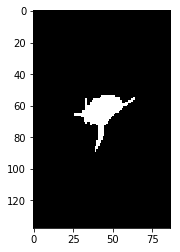

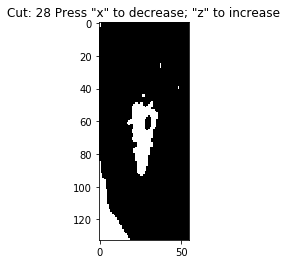

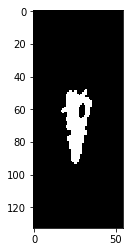

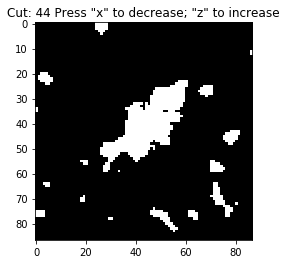

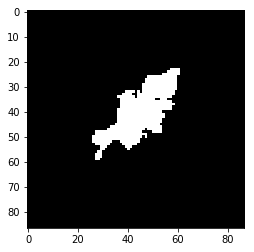

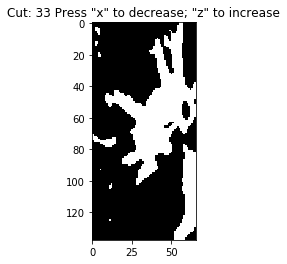

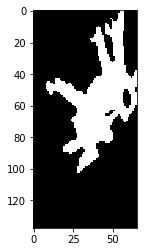

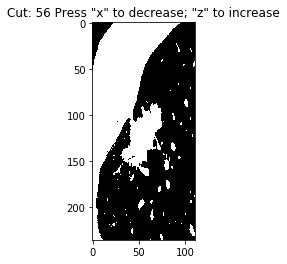

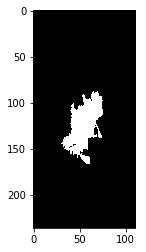

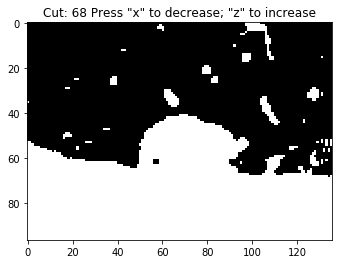

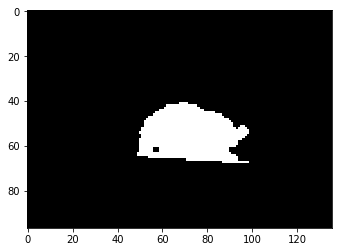

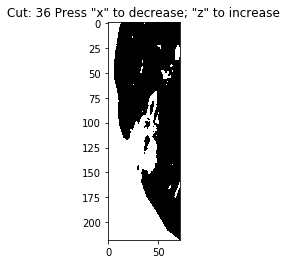

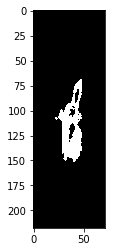

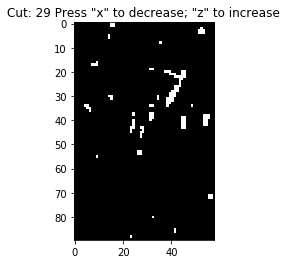

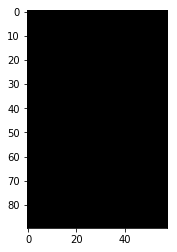

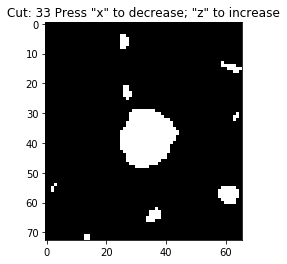

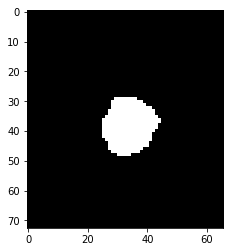

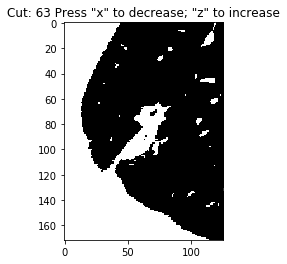

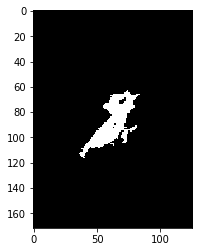

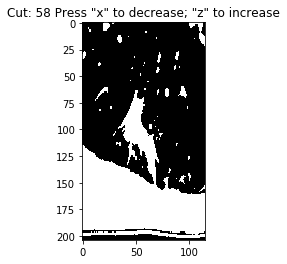

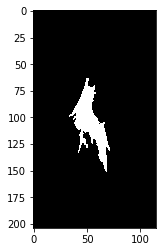

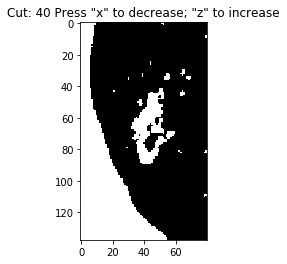

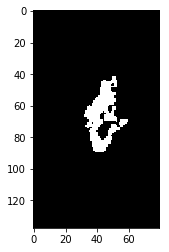

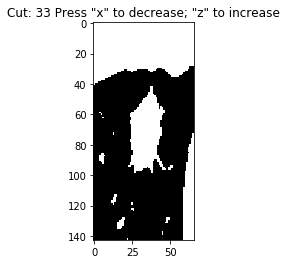

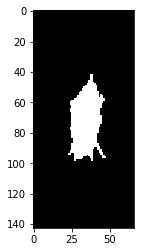

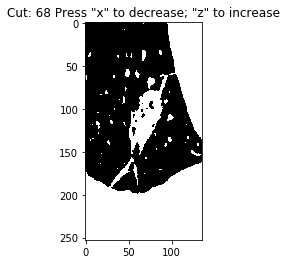

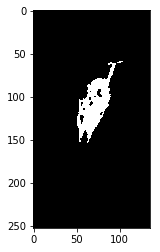

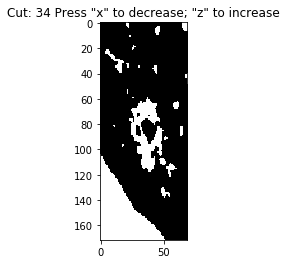

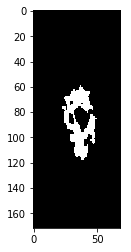

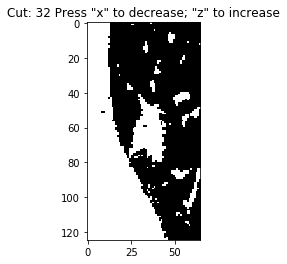

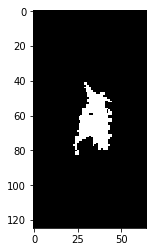

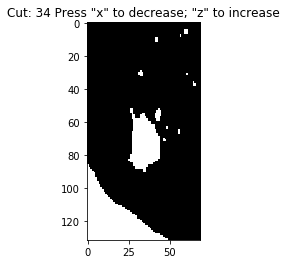

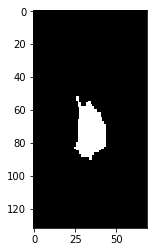

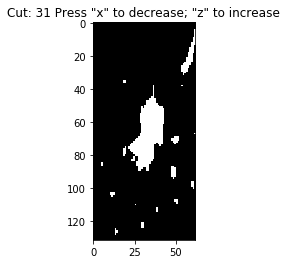

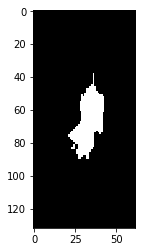

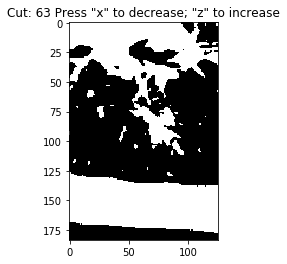

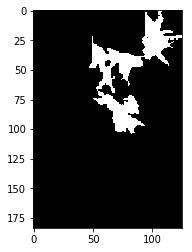

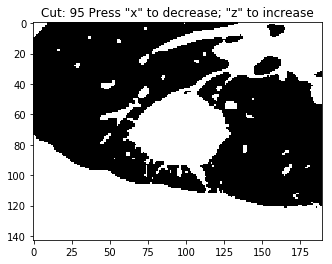

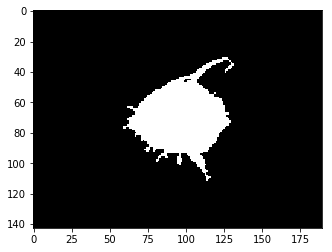

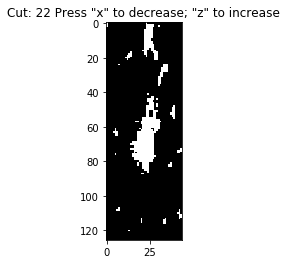

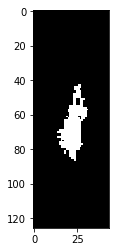

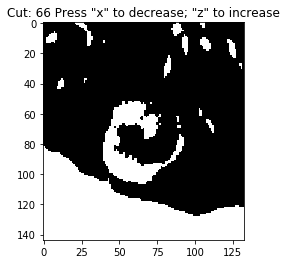

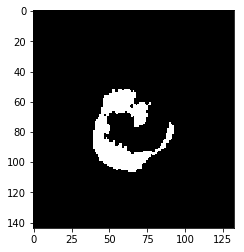

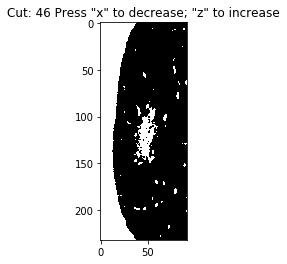

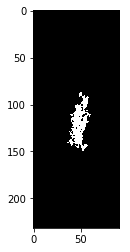

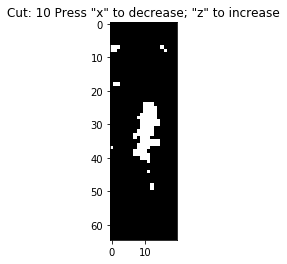

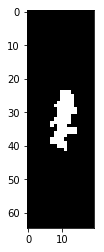

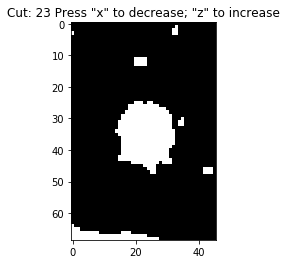

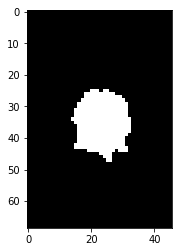

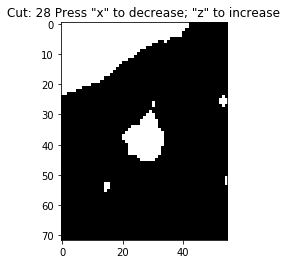

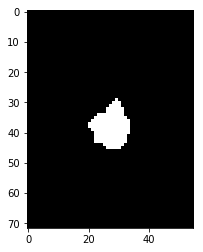

In [ ]:
#Prueba bucle todos los nii's (imagen OTSU y imagen final)
roi_names = [x for x in os.listdir(roi_directory) if x != ".DS_Store"]

for roi_name in roi_names:
    func_filename = os.path.join(roi_directory, roi_name)
    func = nib.load(func_filename)

    roi, meta = IOFunctions.load_nifti_img(os.path.join(roi_directory, roi_name))
    VolumeCutBrowser.VolumeCutBrowser(roi)
    r = ROI(roi, roi_name)
    if proportions_are_valid(r._array):
        r.segment()
        #Guarda l'array de la màscara en format .nii
        ni_img = nib.Nifti1Image(r._nodule, func.affine)
        nib.save(ni_img, 'Segment/'+roi_name+'segment'+'.nii.gz')

segment_names = [x+'segment.nii.gz' for x in roi_names]

# PYRADIOMICS

In [ ]:
import SimpleITK as sitk
import six
from radiomics import featureextractor, getTestCase

In [ ]:
#https://medium.com/@nrk25693/how-to-add-your-conda-environment-to-your-jupyter-notebook-in-just-4-steps-abeab8b8d084
#http://www.radiomics.io/pyradiomics.html
#docs --> https://pyradiomics.readthedocs.io/en/latest/features.html#module-radiomics.shape2D
#examples --> https://github.com/AIM-Harvard/pyradiomics/tree/master/examples

### FEATURE EXTRACTOR

In [ ]:
# hang on to all our features
params = '/Users/puche99/Desktop/MEDICAL/urxe/2- diagnosis challenge/params.yaml'

features = {}
extractor = featureextractor.RadiomicsFeatureExtractor(params)

#Agafem les característiques de totes les imatges, es compara imatge original 3D - segmentació 3D
for x,y in zip(roi_names, segment_names):
    image = '/Users/puche99/Desktop/MEDICAL/urxe/2- diagnosis challenge/Deb/Dades/Nodules/'+x
    mask = '/Users/puche99/Desktop/MEDICAL/urxe/2- diagnosis challenge/Deb/Dades/Segment/'+y
    features[x] = extractor.execute( image, mask )
    
# A list of the valid features, sorted
feature_names = list(sorted(filter ( lambda k: k.startswith("original_"), features['nodule_43.nii'] )))



In [ ]:
#Llegim si els nodes són benignes o malignes i s'afegeix al diccionari característiques
#També afegeix quin tipus de càner és
file1 = open(os.getcwd()+'/Diagnosis/Radiolung_NoduleDiagnosis.csv', 'r')
Lines = file1.readlines()[1:]
 
count = 0
# Strips the newline character
for line in Lines:
    val = line.split(",")
    try:
        features['nodule_'+val[0]+'.nii']['type'] = val[6]
        features['nodule_'+val[0]+'.nii']['label'] = val[4]
    except:
        #print('no nodule'+val[0])
        pass

In [ ]:
#features['nodule_48.nii']['label']
features

{'nodule_1.nii': OrderedDict([('diagnostics_Versions_PyRadiomics', 'v3.0.1'),
              ('diagnostics_Versions_Numpy', '1.19.4'),
              ('diagnostics_Versions_SimpleITK', '2.0.0'),
              ('diagnostics_Versions_PyWavelet', '1.1.1'),
              ('diagnostics_Versions_Python', '3.7.1'),
              ('diagnostics_Configuration_Settings',
               {'minimumROIDimensions': 2,
                'minimumROISize': None,
                'normalize': False,
                'normalizeScale': 1,
                'removeOutliers': None,
                'resampledPixelSpacing': None,
                'interpolator': 'sitkBSpline',
                'preCrop': False,
                'padDistance': 5,
                'distances': [1],
                'force2D': False,
                'force2Ddimension': 0,
                'resegmentRange': None,
                'label': 1,
                'additionalInfo': True,
                'binWidth': 25,
                'weightingNorm': N

In [ ]:
# type of each tumor
def all_indices(value, qlist):
    indices = []
    idx = -1
    while True:
        try:
            idx = qlist.index(value, idx+1)
            indices.append(idx)
        except ValueError:
            break
    return indices

label = [features[x]['label'].split("\n")[0] for x in roi_names]
types = [features[x]['type'].split("\n")[0] for x in roi_names]

key_types = {}
i = 0
for val in set(types):
    key_types[val] = i
    i+=1

int_types = [key_types[x] for x in types]


In [ ]:
#crea un array amb les caracteríques
# Make a numpy array of all the values
samples = np.zeros((len(roi_names),len(feature_names)+1))####+1
count = 1
for i,x in enumerate(roi_names):
    a = np.array([])
    for feature_name in feature_names:
        a = np.append(a, features[x][feature_name])
    a = np.append(a,int_types[i]) ############
    samples[count-1,:] = a
    count +=1
    
# May have NaNs
samples = np.nan_to_num(samples)

### PCA

In [ ]:
#Calcula similaritats per fer PCA en 2D i fer el plot
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

similarities = euclidean_distances(samples)


seed = np.random.RandomState(seed=3)

mds = manifold.MDS(n_components=2, max_iter=5000, eps=1e-12, random_state=seed,
                   n_init=10,
                   dissimilarity="precomputed", n_jobs=1, metric=False)
pos = mds.fit_transform(similarities)

/Users/puche99/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


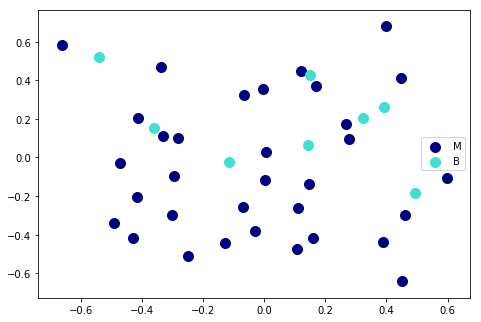

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm


fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])


M = all_indices('Malignant', label)
B = all_indices('Benign', label)
plt.scatter(pos[M, 0], pos[M, 1], color='navy', alpha=1.0, s=100, lw=1, label='M')
plt.scatter(pos[B, 0], pos[B, 1], color='turquoise', alpha=1.0, s=100, lw=1, label='B')

plt.legend(scatterpoints=1, loc=5, shadow=False)

similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0
plt.show()

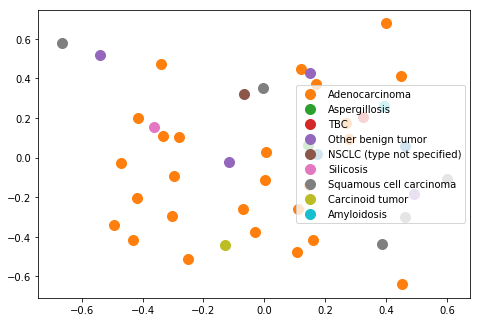

In [ ]:
fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])

for ty in set(types):
    M = all_indices(ty, types)
    plt.scatter(pos[M, 0], pos[M, 1], alpha=1.0, s=100, lw=1, label=ty)

plt.legend(scatterpoints=1, loc=5, shadow=False)
plt.show()


### CORRELATIONS

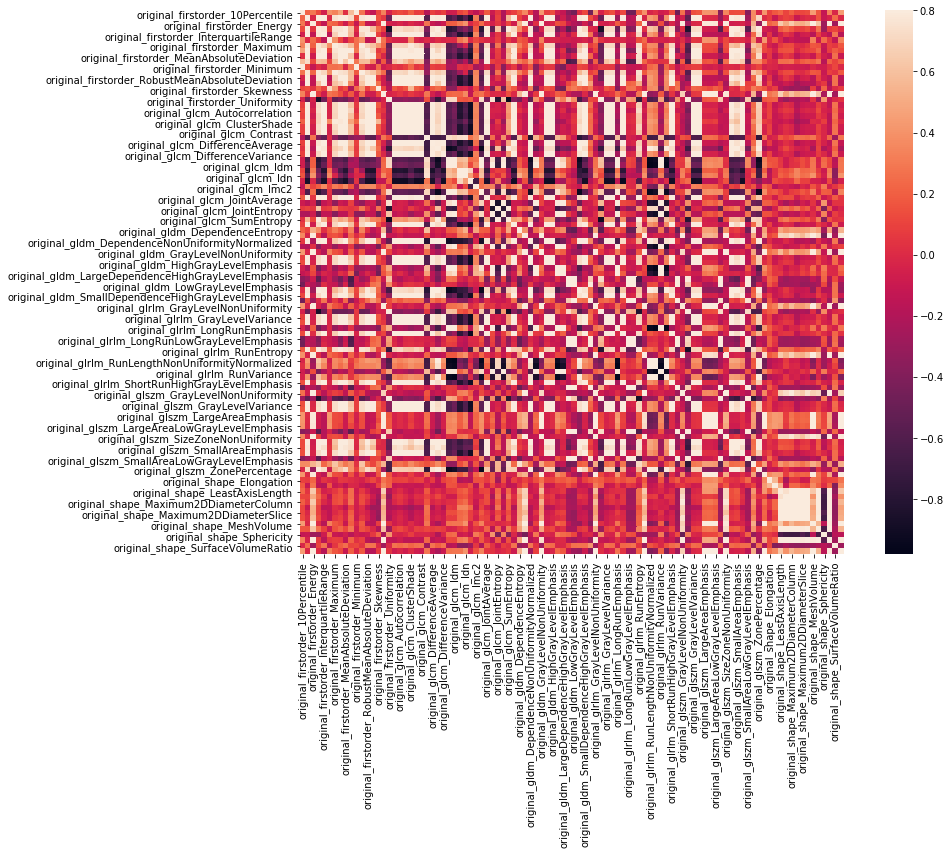

In [ ]:
#Correlació entre els atributs
import pandas as pd
import seaborn as sns


# Construct a pandas dataframe from the samples
d = pd.DataFrame(data=samples, columns=feature_names+['type'], index=label)
d = d.drop(columns=['type'])
d = d[d.index != '']

corr = d.corr()

# Set up the matplotlib figure, make it big!
f, ax = plt.subplots(figsize=(15, 10))

# Draw the heatmap using seaborn
sns.heatmap(corr, vmax=.8, square=True)

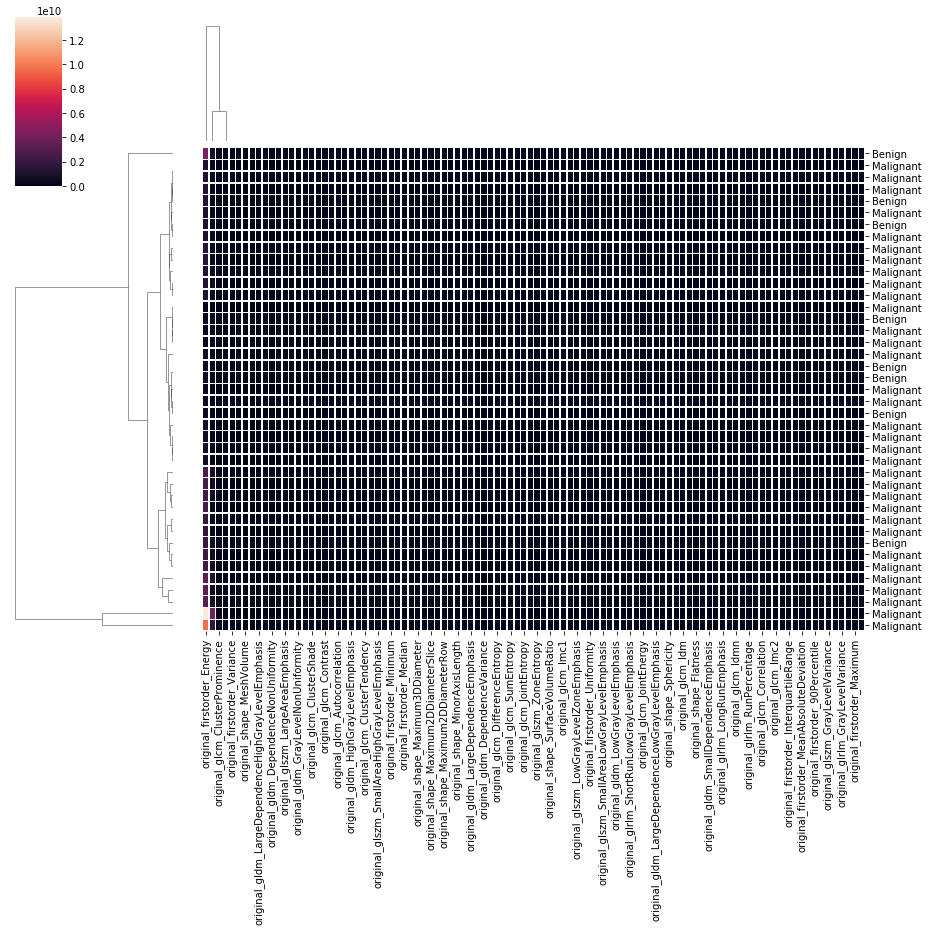

In [ ]:
# Choose a subset of features for clustering
dd = d.iloc[:,1:50]

sns.clustermap(d, linewidths=.5, figsize=(13,13))
m = d.values#as_matrix()

from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(m,'ward')

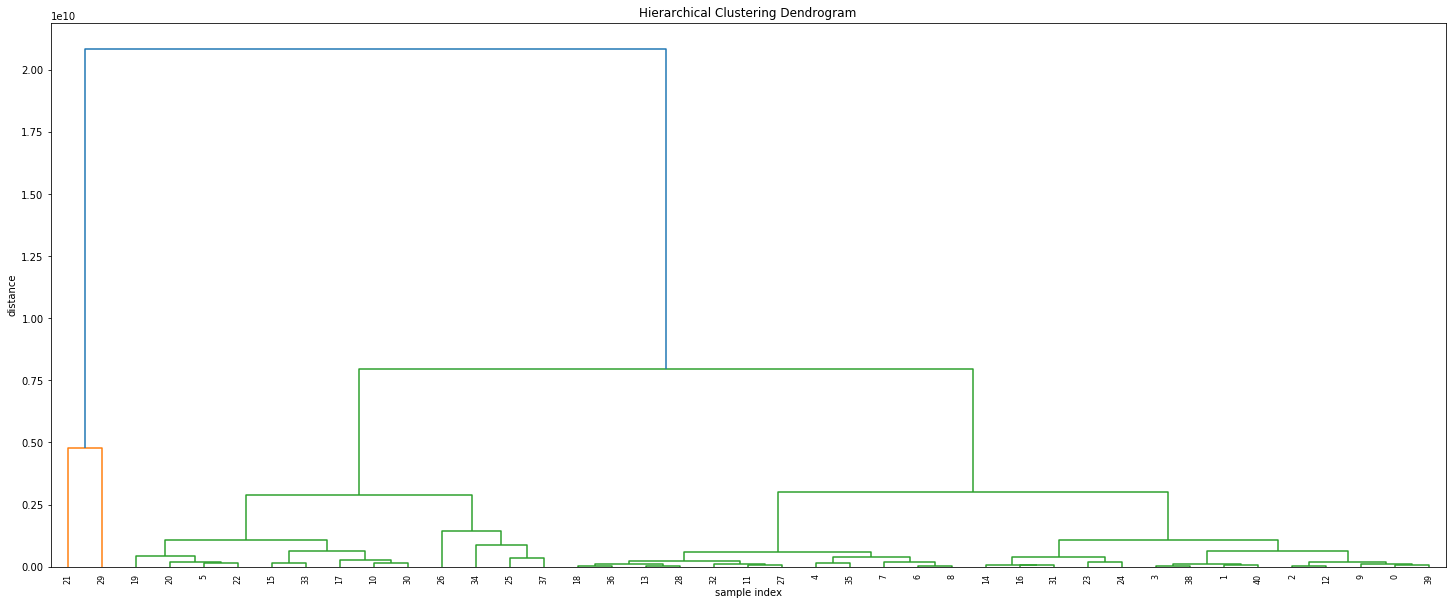

In [ ]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [ ]:
d.head()

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,...,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume
Malignant,-311.0,89.0,3.362491e+08,4.501713,250.00,2.216261,375.0,-88.193551,133.581760,-61.0,...,44.314907,50.079186,52.381436,58.201425,3774.279798,27.460808,0.315946,3710.452050,0.983089,3864.999406
Benign,-372.0,57.0,1.105718e+08,4.281251,281.00,2.000929,209.0,-110.469359,141.640067,-59.0,...,10.485450,12.039971,12.949129,25.171117,38.273740,10.407804,0.233560,235.154302,6.144012,38.790360
Benign,-338.0,92.0,4.481421e+08,4.766541,229.00,10.336409,1354.0,-64.937721,153.143313,-61.0,...,34.930592,24.611087,38.328509,41.219186,1820.745517,16.978047,0.389746,1850.129813,1.016139,1802.847952
Malignant,-420.0,-264.4,6.675088e+07,3.067454,87.00,2.908493,-143.0,-355.248544,48.226939,-368.0,...,10.588460,11.319231,11.337550,11.593339,150.272369,7.682470,0.448878,304.514918,2.026420,159.130096
Malignant,-359.0,136.0,1.373607e+09,4.739676,278.25,2.182682,382.0,-76.059223,151.916557,-39.0,...,75.233724,72.563366,81.155669,97.337856,7864.835825,37.607395,0.195417,9786.978117,1.244397,8091.540760


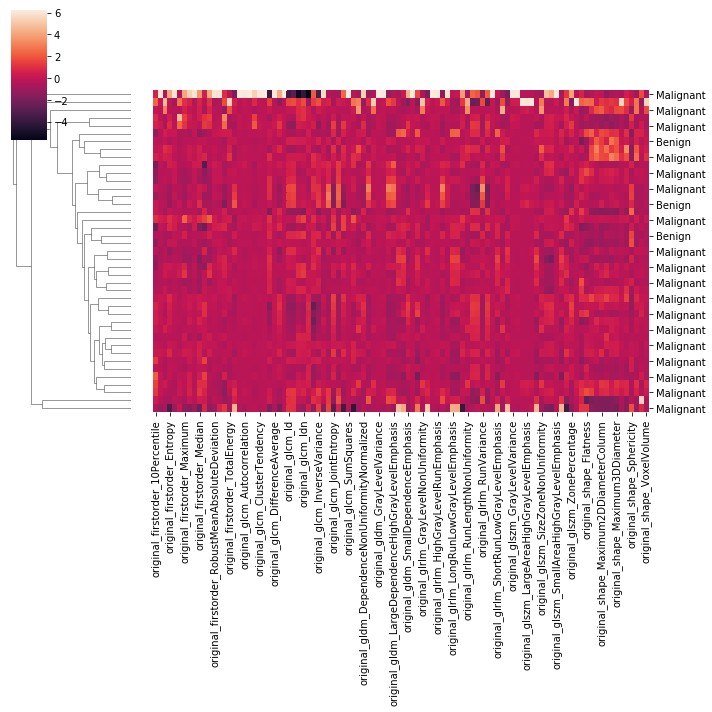

In [ ]:
pp = sns.clustermap(d, col_cluster=False, metric='chebyshev', z_score=1)
_ = plt.setp(pp.ax_heatmap.get_yticklabels(), rotation=0)
plt.show()

### FEATURES RELATED TO CANCER TYPE

In [ ]:
df2 = d.copy()
df2['type'] =  df2.index == 'Malignant'
df2.replace({False: 0, True: 1}, inplace=True)
df2.corr()['type'].abs().sort_values(ascending=False).head(30)

type                                                 1.000000
original_shape_Flatness                              0.279572
original_shape_SurfaceVolumeRatio                    0.243166
original_shape_Elongation                            0.229640
original_glszm_ZoneEntropy                           0.195259
original_firstorder_Kurtosis                         0.175791
original_gldm_SmallDependenceLowGrayLevelEmphasis    0.169665
original_firstorder_Median                           0.154939
original_glcm_SumEntropy                             0.154330
original_glcm_Imc2                                   0.153893
original_gldm_LargeDependenceLowGrayLevelEmphasis    0.145814
original_glcm_MaximumProbability                     0.143043
original_firstorder_RootMeanSquared                  0.142503
original_glszm_SmallAreaLowGrayLevelEmphasis         0.142091
original_firstorder_TotalEnergy                      0.137004
original_glcm_JointEnergy                            0.135231
original

### CREATE NEW SAMPLES

In [ ]:
from sklearn.utils import resample

df_benign = d[d.index == 'Benign']
new_benign = resample(df_benign, replace=True, n_samples=33, random_state=123) 

df_complet =pd.concat([d, new_benign])
df_complet

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,...,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume
Malignant,-311.0,89.0,3.362491e+08,4.501713,250.00,2.216261,375.0,-88.193551,133.581760,-61.0,...,44.314907,50.079186,52.381436,58.201425,3774.279798,27.460808,0.315946,3710.452050,0.983089,3864.999406
Benign,-372.0,57.0,1.105718e+08,4.281251,281.00,2.000929,209.0,-110.469359,141.640067,-59.0,...,10.485450,12.039971,12.949129,25.171117,38.273740,10.407804,0.233560,235.154302,6.144012,38.790360
Benign,-338.0,92.0,4.481421e+08,4.766541,229.00,10.336409,1354.0,-64.937721,153.143313,-61.0,...,34.930592,24.611087,38.328509,41.219186,1820.745517,16.978047,0.389746,1850.129813,1.016139,1802.847952
Malignant,-420.0,-264.4,6.675088e+07,3.067454,87.00,2.908493,-143.0,-355.248544,48.226939,-368.0,...,10.588460,11.319231,11.337550,11.593339,150.272369,7.682470,0.448878,304.514918,2.026420,159.130096
Malignant,-359.0,136.0,1.373607e+09,4.739676,278.25,2.182682,382.0,-76.059223,151.916557,-39.0,...,75.233724,72.563366,81.155669,97.337856,7864.835825,37.607395,0.195417,9786.978117,1.244397,8091.540760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Benign,-372.0,57.0,1.105718e+08,4.281251,281.00,2.000929,209.0,-110.469359,141.640067,-59.0,...,10.485450,12.039971,12.949129,25.171117,38.273740,10.407804,0.233560,235.154302,6.144012,38.790360
Benign,-372.0,57.0,1.105718e+08,4.281251,281.00,2.000929,209.0,-110.469359,141.640067,-59.0,...,10.485450,12.039971,12.949129,25.171117,38.273740,10.407804,0.233560,235.154302,6.144012,38.790360
Benign,-395.0,27.0,2.025234e+09,4.351009,278.00,1.853409,418.0,-150.987262,138.276876,-117.0,...,114.108956,77.961135,159.271029,165.739844,12880.269347,44.924304,0.191605,13868.430759,1.076719,13050.026730
Benign,-338.0,92.0,4.481421e+08,4.766541,229.00,10.336409,1354.0,-64.937721,153.143313,-61.0,...,34.930592,24.611087,38.328509,41.219186,1820.745517,16.978047,0.389746,1850.129813,1.016139,1802.847952


# PROPOSTA 1

In [ ]:
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler




In [ ]:
X, y = df_complet.values, df_complet.index

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7, stratify=y)

XX = PolynomialFeatures(degree=4).fit_transform(X_train).astype(int)
XXX = PolynomialFeatures(degree=4).fit_transform(X_test).astype(int)


clf = Perceptron(fit_intercept=False, max_iter=100, tol=None, shuffle=False).fit(XX, y_train)

XXX = PolynomialFeatures(degree=4).fit_transform(X_test).astype(int)
print('\nTest',clf.score(XXX, y_test))



Test 1.0


In [ ]:
print(classification_report(clf.predict(XXX), y_test))

              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00        13
   Malignant       1.00      1.00      1.00        10

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23



### PROVES

In [ ]:
df_test = d.iloc[:20]
df_benign = d[d.index == 'Benign']
new_benign = resample(df_benign, replace=True, n_samples=45, random_state=123) 
df_malign = d[d.index == 'Malignant']
new_malign = resample(df_malign, replace=True, n_samples=32, random_state=123) 

df_complet =pd.concat([d.iloc[20:], new_benign, new_malign])
np.sum(df_complet.index == 'Malignant')
df_complet

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,...,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume
Malignant,-295.0,112.0,2.592787e+09,4.424714,192.0,2.845042,441.0,-42.679788,122.729542,1.0,...,107.484332,93.318248,78.438156,127.998439,22865.504005,54.022504,0.217413,17919.221904,0.783679,22968.828323
Malignant,-247.0,157.0,1.386759e+10,4.575912,135.0,6.979120,1111.0,-25.300593,124.608877,-37.0,...,112.516520,91.036859,111.200797,127.071269,110365.830213,71.906306,0.324669,34271.503134,0.310526,110313.127973
Malignant,-418.0,33.0,2.551201e+09,4.597694,301.0,3.103717,1158.0,-197.157000,147.700056,-210.0,...,81.255130,84.238026,69.154036,88.438317,5851.145309,36.659489,0.207120,7581.513183,1.295731,5892.762758
Malignant,-353.6,2176.4,6.437942e+08,6.537746,1667.0,1.959541,2806.0,677.675906,841.942644,327.0,...,63.817068,26.184931,48.446491,66.973205,270.552165,47.075751,0.259197,780.467772,2.884722,316.168518
Malignant,-509.0,74.0,7.348895e+08,4.808771,379.0,1.993196,344.0,-148.319910,200.729128,-69.5,...,47.836799,47.331905,47.150702,55.610330,3355.901175,34.232890,0.322983,3356.169217,1.000080,3421.796878
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Malignant,-386.0,91.0,1.103500e+09,4.663596,309.0,2.056286,553.0,-101.998646,161.757853,-53.0,...,60.195024,78.208292,80.482601,102.947555,10120.050467,32.046009,0.264900,8541.290261,0.843997,10252.652647
Malignant,-311.0,89.0,3.362491e+08,4.501713,250.0,2.216261,375.0,-88.193551,133.581760,-61.0,...,44.314907,50.079186,52.381436,58.201425,3774.279798,27.460808,0.315946,3710.452050,0.983089,3864.999406
Malignant,-380.0,178.0,1.905530e+09,4.974738,284.0,2.551516,737.0,-71.945253,167.014320,-44.0,...,97.469447,48.942988,79.881201,104.069312,8668.785037,36.598405,0.265770,7678.633057,0.885780,8786.035284
Malignant,-443.0,13.0,5.893594e+08,4.124408,318.0,1.825537,67.0,-160.622244,157.623404,-85.0,...,57.395832,50.377637,71.762722,81.565406,2371.168327,28.763992,0.417473,2059.828643,0.868698,2415.177977


In [ ]:
X, y = df_complet.values, df_complet.index


XX = PolynomialFeatures(degree=4).fit_transform(X).astype(int)


clf = Perceptron(fit_intercept=False, max_iter=100, tol=None, shuffle=False).fit(XX, y)


XXXR = PolynomialFeatures(degree=4).fit_transform(df_test.values).astype(int)
print('\nTest real data',clf.score(XXXR, df_test.index))
print(clf.predict(XXXR))
print(df_test.index)


Test real data 1.0
['Benign' 'Malignant' 'Malignant' 'Malignant' 'Malignant' 'Malignant'
 'Malignant' 'Malignant' 'Malignant' 'Malignant' 'Malignant' 'Benign'
 'Malignant']
Index(['Benign', 'Malignant', 'Malignant', 'Malignant', 'Malignant',
       'Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant',
       'Malignant', 'Benign', 'Malignant'],
      dtype='object')


###  PROVA REAL DATA SEPARAT

In [ ]:

df_test = d.iloc[:20]
df_split = d.iloc[20:]

df_benign = df_split[df_split.index == 'Benign']
df_malign = df_split[df_split.index == 'Malignant']

new_benign = resample(df_benign, replace=True, n_samples=45, random_state=123) 
new_malign = resample(df_malign, replace=True, n_samples=32, random_state=123) 

df_complet =pd.concat([df_split, new_benign, new_malign])


In [ ]:
df2 = df_complet.copy()
df2['type'] =  df2.index == 'Malignant'
df2.replace({False: 0, True: 1}, inplace=True)
df2.corr()['type'].abs().sort_values(ascending=False).head(5)

type                                            1.000000
original_glszm_SmallAreaLowGrayLevelEmphasis    0.546917
original_firstorder_Skewness                    0.481591
original_glszm_LowGrayLevelZoneEmphasis         0.445891
original_glszm_ZoneEntropy                      0.443289
Name: type, dtype: float64

In [ ]:
X, y = df_complet.values, df_complet.index

XX = PolynomialFeatures(degree=4).fit_transform(X).astype(int)
sc = StandardScaler()
XX = sc.fit_transform(XX)
XXXR = PolynomialFeatures(degree=4).fit_transform(df_test.values).astype(int)



In [ ]:
X[:5,:2]

array([[-295. ,  112. ],
       [-247. ,  157. ],
       [-418. ,   33. ],
       [-353.6, 2176.4],
       [-509. ,   74. ]])

In [ ]:
XX[:5,:2]

array([[ 0.        ,  1.65821214],
       [ 0.        ,  2.48249935],
       [ 0.        , -0.45402385],
       [ 0.        ,  0.66219842],
       [ 0.        , -2.01673502]])

In [ ]:
clf = Perceptron(max_iter=100,tol=None, shuffle=True).fit(XX, y)

print('\nTest real data',clf.score(XXXR, df_test.index))
print(clf.predict(XXXR))
print(df_test.index)

In [ ]:
(y == 'Benign')*1

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from torch.utils.data import Dataset, DataLoader
class dataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.length = self.x.shape[0]
 
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    def __len__(self):
        return self.length
yy = (y == 'Benign')*1
trainset = dataset(XX,yy)
#DataLoader
trainloader = DataLoader(trainset,batch_size=64,shuffle=False)

from torch import nn
from torch.nn import functional as F
class Net(nn.Module):
    def __init__(self,input_shape):
            super(Net,self).__init__()
            self.fc1 = nn.Linear(input_shape,32)
            self.fc2 = nn.Linear(32,64)
            self.fc3 = nn.Linear(64,1)
    def forward(self,x):
            x = torch.relu(self.fc1(x))
            x = torch.relu(self.fc2(x))
            x = torch.sigmoid(self.fc3(x))
            return x
        
learning_rate = 0.01
epochs = 700
# Model , Optimizer, Loss
model = Net(input_shape=XX.shape[1])
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()

In [ ]:
#forward loop
losses = []
accur = []
for i in range(epochs):
    for j,(x_train,y_train) in enumerate(trainloader):

            #calculate output
            output = model(x_train)

            #calculate loss
            loss = loss_fn(output,y_train.reshape(-1,1))

            #accuracy
            predicted = model(torch.tensor(XX,dtype=torch.float32))
            acc = (predicted.reshape(-1).detach().numpy().round() == yy).mean()
            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    if i%1 == 0:
            losses.append(loss)
            accur.append(acc)
            print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))


epoch 0	loss : 1.1067001819610596	 accuracy : 0.5816326530612245


In [ ]:
#plotting the loss
plt.plot(losses)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')

In [ ]:
#printing the accuracy
plt.plot(accur)
plt.title('Accuracy vs Epochs')
plt.xlabel('Accuracy')
plt.ylabel('loss')

In [ ]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

param_grid = {'penalty':['l2','l1','elasticnet'], 'alpha':[0.00001,0.0001,0.001]}
base_estimator = Perceptron(max_iter=200, penalty = 'elasticnet',tol=None, shuffle=True)
sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5, factor=2, resource='n_estimators', max_resources=30).fit(XX, y)
sh.best_estimator_



In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier
X, y = df_complet.values, df_complet.index


XX = PolynomialFeatures(degree=4).fit_transform(X).astype(int)


est = make_pipeline(StandardScaler(), SGDClassifier())
est.fit(XX,y)
XXXR = PolynomialFeatures(degree=4).fit_transform(df_test.values).astype(int)
print('\nTest real data',est.score(XXXR, df_test.index))
print(est.predict(XXXR))
print(df_test.index)


Test real data 0.75
['Malignant' 'Malignant' 'Malignant' 'Malignant' 'Malignant' 'Malignant'
 'Malignant' 'Malignant' 'Malignant' 'Malignant' 'Malignant' 'Benign'
 'Malignant' 'Malignant' 'Malignant' 'Malignant' 'Malignant' 'Malignant'
 'Malignant' 'Benign']
Index(['Malignant', 'Benign', 'Benign', 'Malignant', 'Malignant', 'Malignant',
       'Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant',
       'Benign', 'Benign', 'Malignant', 'Malignant', 'Malignant', 'Malignant',
       'Benign', 'Malignant', 'Malignant'],
      dtype='object')


In [ ]:
X, y = df_complet.values, df_complet.index

XX = PolynomialFeatures(degree=4).fit_transform(X).astype(int)

clf = Perceptron(max_iter=200, penalty = 'elasticnet',tol=None, shuffle=True).fit(XX, y)

XXXR = PolynomialFeatures(degree=4).fit_transform(df_test.values).astype(int)
print('\nTest real data',clf.score(XXXR, df_test.index))
print(clf.predict(XXXR))
print(df_test.index)

# EXTRA PROVES

In [ ]:

df_Sbenign = d[d.index == 'Benign']
df_Smalign = d[d.index == 'Malignant']
df_test = pd.concat([df_Sbenign.iloc[:2],df_Smalign.iloc[:16]])
df_split = pd.concat([df_Smalign.iloc[16:],df_Sbenign.iloc[2:]])
df_benign = df_split[df_split.index == 'Benign']
df_malign = df_split[df_split.index == 'Malignant']

new_benign = resample(df_benign, replace=True, n_samples=46, random_state=123) 
new_malign = resample(df_malign, replace=True, n_samples=35, random_state=123) 

df_complet =pd.concat([df_split, new_benign, new_malign])
#np.sum(df_complet.index == 'Malignant')

In [ ]:
X, y = d.values, d.index

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7, stratify=y)

XX = PolynomialFeatures(degree=4).fit_transform(X_train).astype(int)
XXX = PolynomialFeatures(degree=4).fit_transform(X_test).astype(int)

clf = Perceptron(fit_intercept=False, max_iter=100, tol=None, shuffle=False).fit(XX, y_train)

XXXR = PolynomialFeatures(degree=4).fit_transform(X_test).astype(int)
print('\nTest real data',clf.score(XXXR, y_test))
print(clf.predict(XXXR))
print(y_test)


Test real data 0.7272727272727273
['Malignant' 'Malignant' 'Benign' 'Malignant' 'Malignant' 'Malignant'
 'Malignant' 'Malignant' 'Malignant' 'Malignant' 'Malignant']
Index(['Benign', 'Malignant', 'Malignant', 'Malignant', 'Malignant',
       'Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant',
       'Benign'],
      dtype='object')


# PROPOSTA 2

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

X, y = d.values, d.index

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.15, random_state=123, stratify=y)

In [ ]:
clf = GradientBoostingClassifier(n_estimators=50, max_depth=3, random_state=12)
clf.fit(X_train, y_train)
#print confusion matrix of test set
print(classification_report(clf.predict(X_test), y_test))
#print accuracy score of the test set
print(f"Test Accuracy: {np.mean(clf.predict(X_test) == y_test)*100:.2f}%")

              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00         2
   Malignant       0.67      0.80      0.73         5

    accuracy                           0.57         7
   macro avg       0.33      0.40      0.36         7
weighted avg       0.48      0.57      0.52         7

Test Accuracy: 57.14%


## PROVES DL

In [ ]:
df_benign = d[d.index == 'Benign']
df_malign = d[d.index == 'Malignant']


new_benign = resample(df_benign, replace=True, n_samples=380, random_state=123) 
new_malign = resample(df_malign, replace=True, n_samples=420, random_state=123) 


df_complet2 =pd.concat([d, new_benign, new_malign])
df_complet2

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,...,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume
Malignant,-311.0,89.0,3.362491e+08,4.501713,250.00,2.216261,375.0,-88.193551,133.581760,-61.0,...,44.314907,50.079186,52.381436,58.201425,3774.279798,27.460808,0.315946,3710.452050,0.983089,3864.999406
Benign,-372.0,57.0,1.105718e+08,4.281251,281.00,2.000929,209.0,-110.469359,141.640067,-59.0,...,10.485450,12.039971,12.949129,25.171117,38.273740,10.407804,0.233560,235.154302,6.144012,38.790360
Benign,-338.0,92.0,4.481421e+08,4.766541,229.00,10.336409,1354.0,-64.937721,153.143313,-61.0,...,34.930592,24.611087,38.328509,41.219186,1820.745517,16.978047,0.389746,1850.129813,1.016139,1802.847952
Malignant,-420.0,-264.4,6.675088e+07,3.067454,87.00,2.908493,-143.0,-355.248544,48.226939,-368.0,...,10.588460,11.319231,11.337550,11.593339,150.272369,7.682470,0.448878,304.514918,2.026420,159.130096
Malignant,-359.0,136.0,1.373607e+09,4.739676,278.25,2.182682,382.0,-76.059223,151.916557,-39.0,...,75.233724,72.563366,81.155669,97.337856,7864.835825,37.607395,0.195417,9786.978117,1.244397,8091.540760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Malignant,-399.0,-90.0,1.284990e+09,4.053656,209.25,1.855516,87.0,-227.440706,104.711587,-203.0,...,62.386261,47.613831,68.846881,74.350533,7453.242826,35.093287,0.195079,9458.809944,1.269087,7661.925765
Malignant,-457.0,27.0,1.589358e+08,4.623490,334.00,1.810473,273.0,-197.503887,160.830691,-190.0,...,30.441193,36.673509,40.084292,45.855382,656.102657,19.237577,0.447477,816.008270,1.243720,675.762177
Malignant,-420.0,-31.0,1.215250e+09,4.332937,253.00,1.753656,81.0,-226.633141,123.865142,-230.0,...,60.156567,45.234156,53.018423,67.471348,3296.532898,42.499906,0.320980,3337.161350,1.012325,3358.256836
Malignant,-247.0,157.0,1.386759e+10,4.575912,135.00,6.979120,1111.0,-25.300593,124.608877,-37.0,...,112.516520,91.036859,111.200797,127.071269,110365.830213,71.906306,0.324669,34271.503134,0.310526,110313.127973


In [ ]:
X, y = df_complet2.values, df_complet2.index

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7, stratify=y)

XX = PolynomialFeatures(degree=4).fit_transform(X_train).astype(int)
XXX = PolynomialFeatures(degree=4).fit_transform(X_test).astype(int)


clf = Perceptron(fit_intercept=False, max_iter=100, tol=None, shuffle=False).fit(XX, y_train)
print("Train",clf.score(XX, y_train))
print(clf.predict(XX))
print(y_train)

XXX = PolynomialFeatures(degree=4).fit_transform(X_test).astype(int)
print('\nTest',clf.score(XXX, y_test))
print(clf.predict(XXX))
print(y_test)

XXXB = PolynomialFeatures(degree=4).fit_transform(df_complet[df_complet.index == 'Benign'].values).astype(int)
print('\nBenign\n',clf.predict(XXXB))
print(clf.score(XXXB, list(df_complet[df_complet.index == 'Benign'].index)))

XXXM = PolynomialFeatures(degree=4).fit_transform(df_complet[df_complet.index == 'Malignant'].values).astype(int)
print('\nMalignant\n',clf.predict(XXXM))
print(clf.score(XXXM, list(df_complet[df_complet.index == 'Malignant'].index)))

In [ ]:
X, y = d.iloc[4:].values, d.iloc[4:].index

XX = PolynomialFeatures(degree=4).fit_transform(X).astype(int)

clf = Perceptron(fit_intercept=False, max_iter=100, tol=None, shuffle=False).fit(XX, y)
print(clf.predict(XX))
print(clf.score(XX, y))
XXX = PolynomialFeatures(degree=4).fit_transform(d.iloc[:4].values).astype(int)

print(clf.predict(XXX))

['Malignant' 'Malignant' 'Malignant' 'Malignant' 'Malignant' 'Malignant'
 'Malignant' 'Benign' 'Benign' 'Malignant' 'Malignant' 'Malignant'
 'Malignant' 'Benign' 'Malignant' 'Malignant' '' 'Malignant' 'Malignant'
 'Malignant' 'Malignant' 'Malignant' 'Malignant' 'Benign' 'Malignant'
 'Benign' 'Malignant' 'Malignant' 'Malignant' 'Malignant' 'Malignant'
 'Malignant' 'Malignant' 'Malignant' '' 'Malignant' 'Malignant' 'Benign'
 'Malignant']
1.0
['Benign' 'Malignant' 'Benign' 'Malignant']


In [ ]:
X, y = d.values, d.index

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.20, random_state=0, stratify=y)

XX = PolynomialFeatures(degree=4).fit_transform(X_train).astype(int)
XXX = PolynomialFeatures(degree=4).fit_transform(X_test).astype(int)


clf = Perceptron(fit_intercept=False, max_iter=100, tol=None, shuffle=False).fit(XX, y_train)
print("Train")
print(clf.predict(XX))
print(y_train)
print(clf.score(XX, y_train))


XXX = PolynomialFeatures(degree=4).fit_transform(X_test).astype(int)
print('Test')
print(clf.predict(XXX))
print(y_test)
print(clf.score(XXX, y_test))

Train
['Malignant' 'Malignant' 'Malignant' 'Malignant' 'Malignant' 'Malignant'
 'Benign' 'Malignant' 'Malignant' 'Malignant' 'Malignant' 'Malignant'
 'Malignant' 'Malignant' 'Malignant' 'Malignant' 'Malignant' 'Benign'
 'Benign' 'Benign' 'Malignant' 'Malignant' 'Benign' 'Malignant'
 'Malignant' 'Benign' 'Malignant' 'Malignant' 'Malignant' '' 'Malignant'
 'Malignant' '' 'Malignant']
Index(['Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant',
       'Malignant', 'Benign', 'Malignant', 'Malignant', 'Malignant',
       'Malignant', 'Malignant', 'Malignant', 'Malignant', 'Malignant',
       'Malignant', 'Malignant', 'Benign', 'Benign', 'Benign', 'Malignant',
       'Malignant', 'Benign', 'Malignant', 'Malignant', 'Benign', 'Malignant',
       'Malignant', 'Malignant', '', 'Malignant', 'Malignant', '',
       'Malignant'],
      dtype='object')
1.0
Test
['Malignant' 'Malignant' 'Malignant' 'Malignant' 'Malignant' 'Malignant'
 'Malignant' 'Malignant' 'Malignant']
Index(['Malignant

In [ ]:
from sklearn import manifold, datasets

X, y = d.values, d.index
n_samples, n_features = X.shape

from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier


clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2,random_state=0)
scores = cross_val_score(clf, X, y, cv=5)
print(scores.mean())


clf = RandomForestClassifier(n_estimators=10, max_depth=None,min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X, y, cv=5)
print(scores.mean())



clf = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X, y, cv=5)
print(scores.mean())



0.7416666666666666
0.6305555555555555
0.7416666666666666


/Users/puche99/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/puche99/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/puche99/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
model = Pipeline([('poly', PolynomialFeatures(degree=3)),('linear', LinearRegression(fit_intercept=False))])
x = np.arange(5)
y = 3 - 2 * x + x ** 2 - x ** 3
model = model.fit(x[:, np.newaxis], y)
model.named_steps['linear'].coef_


array([ 3., -2.,  1., -1.])

/Users/puche99/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


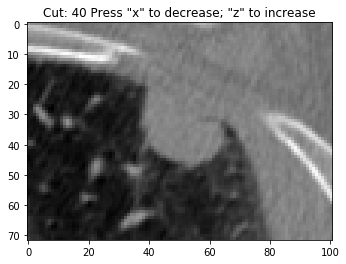

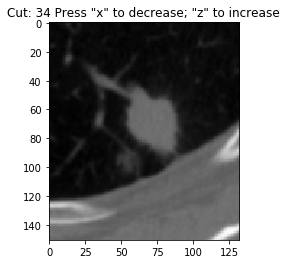

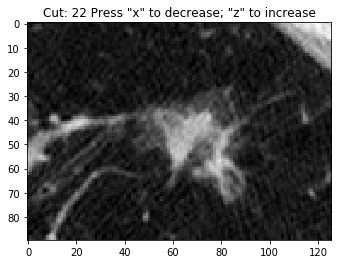

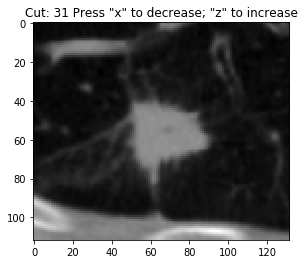

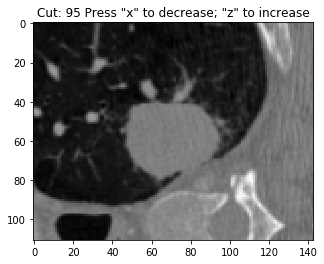

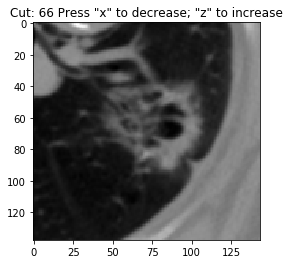

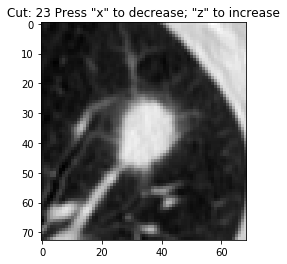

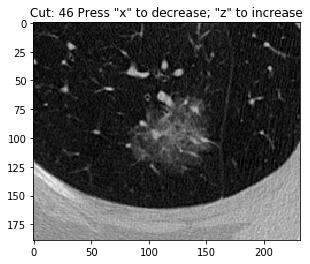

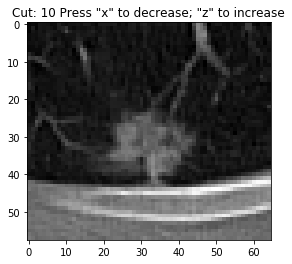

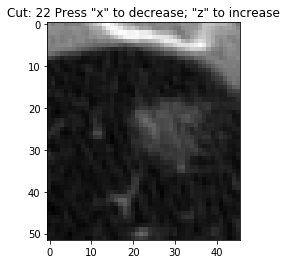

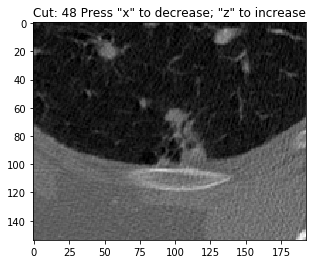

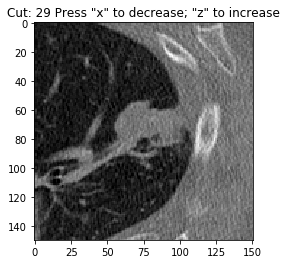

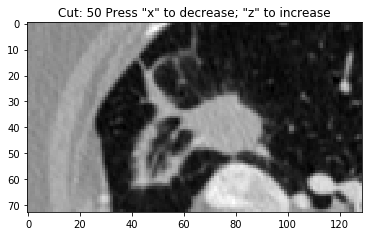

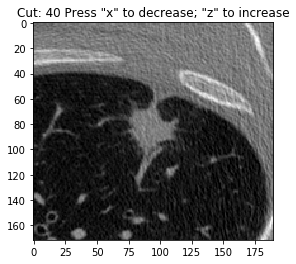

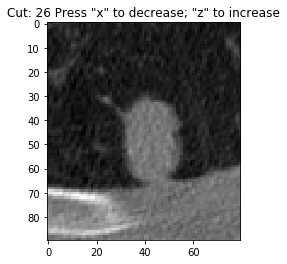

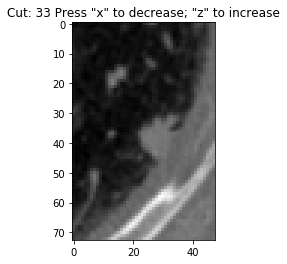

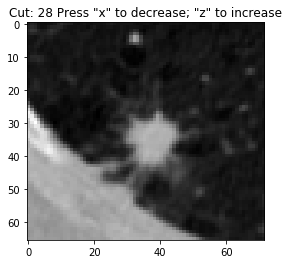

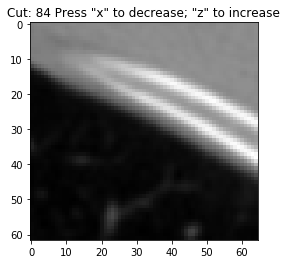

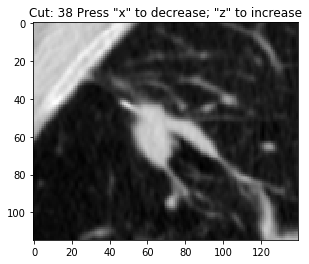

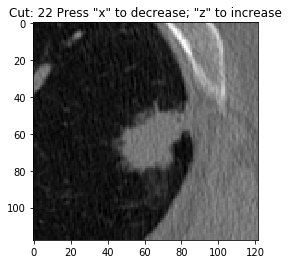

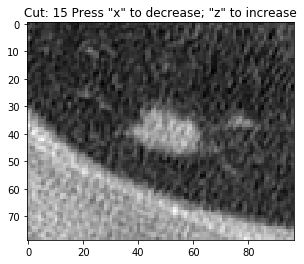

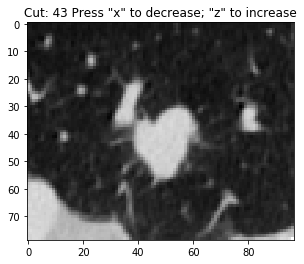

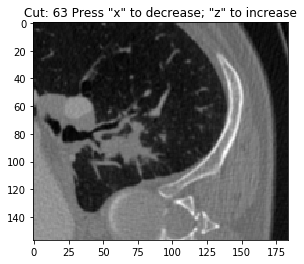

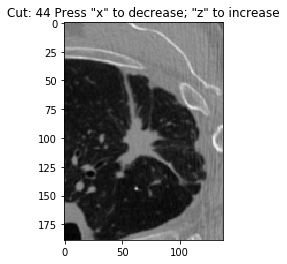

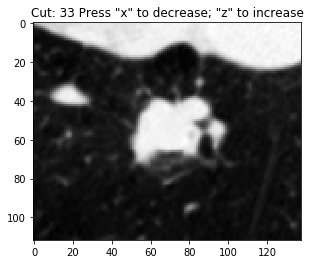

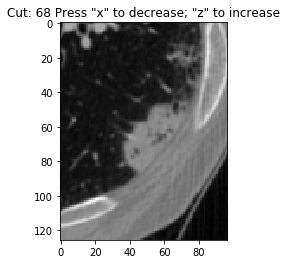

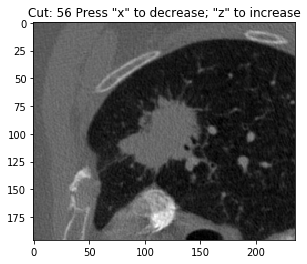

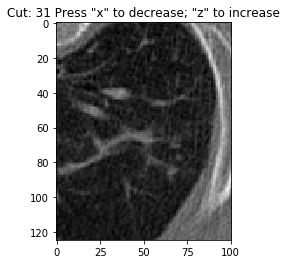

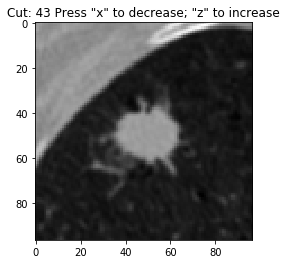

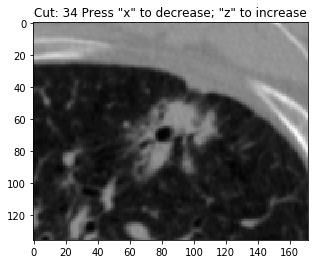

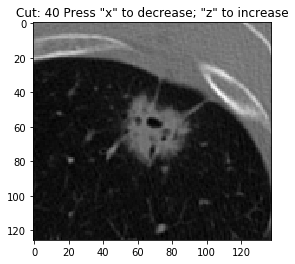

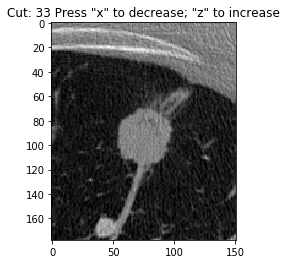

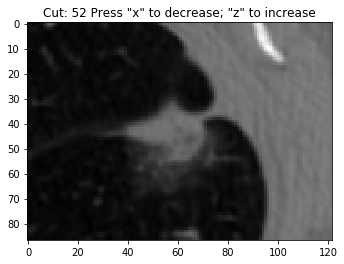

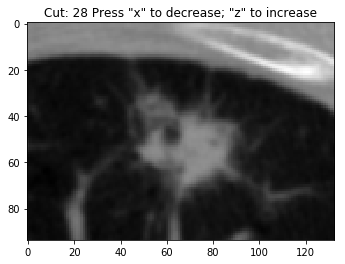

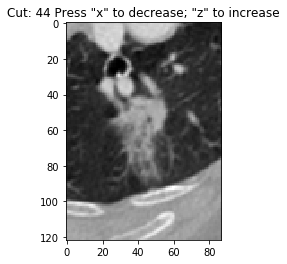

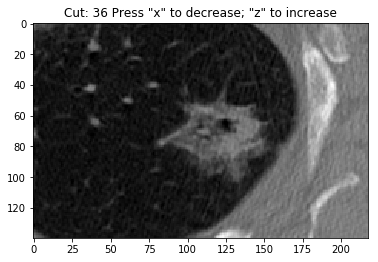

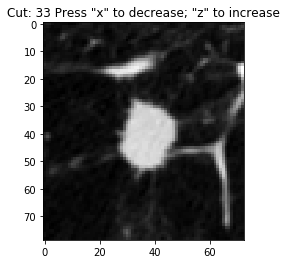

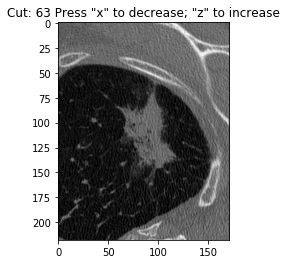

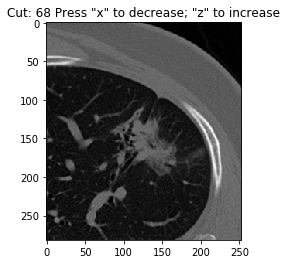

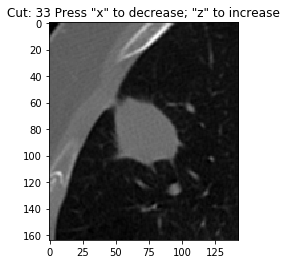

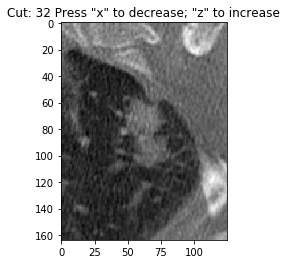

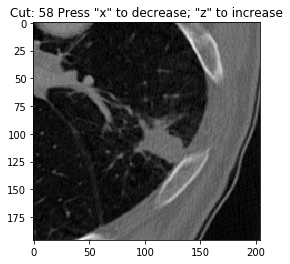

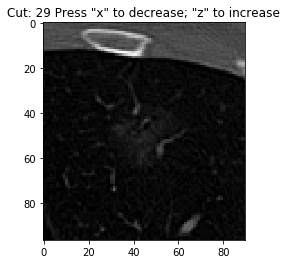

In [ ]:
#guardar segments en comptes de la imatge,
#posar imatge al mig
#label de la imatge
list_nodules = []
for i in range(80):
    try: 
        nodule_name = 'nodule_'+str(i)+'.nii'
        roi_1, meta = IOFunctions.load_nifti_img(os.path.join(current_directory, "Nodules", nodule_name))
        VolumeCutBrowser.VolumeCutBrowser(roi_1)
        list_nodules.append(ROI(roi_1, nodule_name))
    except:
        pass
max_size = [max([x.array.shape[0] for x in list_nodules]),max([y.array.shape[1] for y in list_nodules]),max([z.array.shape[2] for z in list_nodules])]



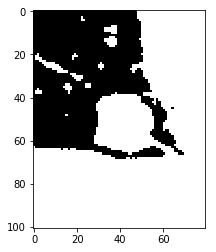

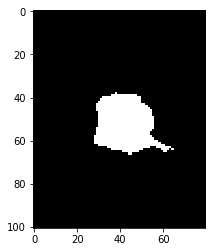

In [ ]:
list_nodules[0].segment()


In [ ]:
new_nodules = [np.zeros(shape=max_size) for i in range(len(list_nodules))]
label_nodules = [np.array([0.]) for x in range(len(list_nodules))]
for i,val in enumerate(list_nodules):
    x= max_size[0] - val.array.shape[0]
    y = max_size[1] - val.array.shape[1]
    z = max_size[2] - val.array.shape[2]
    new_nodules[i][x:,y:,z:] = val.array


In [ ]:
len(new_nodules)
new_nodules[10].shape

(282, 253, 190)

In [ ]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import time

plt.ion()

In [ ]:
!pip install numpy
!pip install --pre torch torchvision -f 
!https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

-f option requires 1 argument
/bin/sh: https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html: No such file or directory


In [ ]:
import torch
from torchvision import transforms, datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
image_datasets = {x: [data_transforms[x](torch.Tensor(new_nodules[i])) for i in range(len(new_nodules))]
                  for x in ['train', 'val']}

In [ ]:
image_datasets
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                              shuffle=True, num_workers=8)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
dataset_sizes

{'train': 43, 'val': 43}

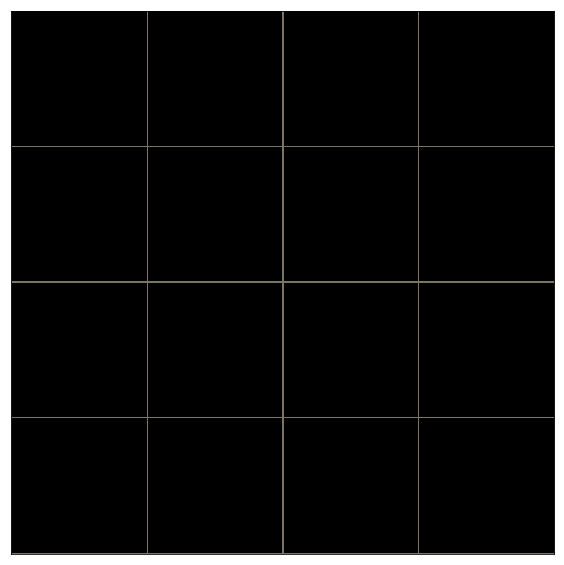

In [ ]:
import torchvision

def imshow(inp, title=None, ax=None, figsize=(5, 5)):
      """Imshow for Tensor."""
      inp = inp.numpy().transpose((1, 2, 0))
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      inp = std * inp + mean
      inp = np.clip(inp, 0, 1)
      if ax is None:
        fig, ax = plt.subplots(1, figsize=figsize)
      ax.imshow(inp)
      ax.set_xticks([])
      ax.set_yticks([])
      if title is not None:
        ax.set_title(title)

# Get a batch of training data
#inputs, classes = next(iter(dataloaders['train']))
inputs = next(iter(dataloaders['train']))


# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

fig, ax = plt.subplots(1, figsize=(10, 10))
#imshow(out, title=[class_names[x] for x in classes], ax=ax)
imshow(out, title='', ax=ax)